In [ ]:
# Custom Veri Seti Kullanarak Askeri Uçak Görüntü Sınıflandırma

# Önceden eğitilmiş VGG16 karmaşık derin öğrenme modelini kullanıldı.

# MTARSI'den (Uzaktan Algılama Görüntülerinin Çok Tipli Uçağı, https://zenodo.org/record/3464319#.YUiSrrgzaUk) uçak görüntüleri veri seti olarak kullanıldı, 
# ancak veri seti boyutu küçültüldü ve görüntüler eğitim amaçlı olarak yeniden düzenlendi.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from PIL import Image

In [13]:
train_file_path = "airplanedataset/Train/"
test_file_path = "airplanedataset/Test/"

In [17]:
img = load_img(train_file_path +  "B-52/3-100.jpg")

In [21]:
print(img_to_array(img).shape)

(206, 206, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

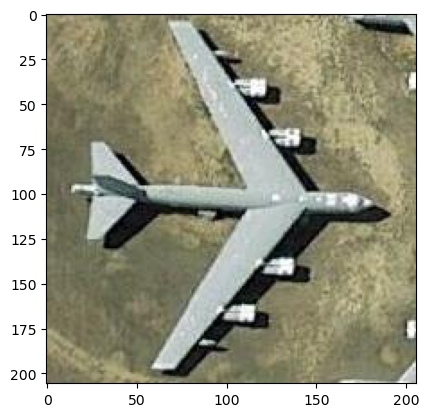

In [23]:
plt.imshow(img)
plt.show

In [25]:
# ImageDataGenerator() -> ImageDataGenerator sınıfı, görüntü verilerini ön işlemek ve artırmak için kullanılır.
# Örneğin, resimleri yeniden boyutlandırmak, normalleştirmek ya da veri artırma (data augmentation) gibi işlemlerle modelin daha iyi öğrenmesini sağlar.
# Burada, herhangi bir parametre verilmeden oluşturulduğu için varsayılan olarak sadece görüntüleri olduğu gibi yükler 
# (örneğin, veri artırma yoktur).

# flow_from_directory() -> Bu metodun amacı, belirtilen dizinlerdeki alt klasörlerden veri yüklemek ve sınıfları otomatik olarak etiketlemektir. 
# Her alt klasör bir sınıfı temsil eder.

# low_from_directory fonksiyonu, resimleri yükler ve x, y formatında numpy tensörleri döndürür
# x: Yeniden boyutlandırılmış görüntüler.
# y: Bu görüntülere ait sınıf etiketleri.


train_data = ImageDataGenerator().flow_from_directory(train_file_path,target_size=(224,224))
test_data = ImageDataGenerator().flow_from_directory(test_file_path,target_size=(224,224))

Found 1812 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [27]:
numberOfAirplaneTypes = 5

# eğer başka bir uçak türü yüklenirse bu sayının değişmesi gerekiyor.

In [29]:
# ImageNet: Yaklaşık 15 milyon etiketli yüksek çözünürlüklü görüntü içeren ve 22.000 kategoriye ait bir veri setidir.
# Model, 1000 farklı görüntü kategorisi için tasarlanmıştır (örneğin, kedi, köpek, araba) 
# ancak bu kategoriler arasında uçak görüntüleri gibi spesifik sınıflar bulunmaz.

# VGG16, önceden eğitilmiş katmanlarıyla genel özellik çıkarımında başarılıdır, ancak ImageNet'te eğitildiği için uçak görüntüleri sınıflandırmasına uygun değildir.
# Bu yüzden, uçak görüntülerini sınıflandırmak için yeni bir model oluşturacağız.
# Yeni modelde, VGG16’nın önceden eğitilmiş katmanlarını kullanacağız ve son katmanları uçak kategorilerimize uygun olarak değiştireceğiz. 
# Bu, transfer öğrenimi sayesinde hem eğitim süresini kısaltır hem de performansı artırır.
 
# Kısaca Önceden eğitilmiş VGG16 katmanları, uçak görüntüleri için özellik çıkarımında bize avantaj sağlar, 
# ancak uçakları ayırabilmek için son katmanları projemize uygun şekilde yeniden inşa etmemiz gerekiyor.

vgg = VGG16()

In [31]:
vgg_layers = vgg.layers

print(vgg_layers)

[<InputLayer name=input_layer, built=True>, <Conv2D name=block1_conv1, built=True>, <Conv2D name=block1_conv2, built=True>, <MaxPooling2D name=block1_pool, built=True>, <Conv2D name=block2_conv1, built=True>, <Conv2D name=block2_conv2, built=True>, <MaxPooling2D name=block2_pool, built=True>, <Conv2D name=block3_conv1, built=True>, <Conv2D name=block3_conv2, built=True>, <Conv2D name=block3_conv3, built=True>, <MaxPooling2D name=block3_pool, built=True>, <Conv2D name=block4_conv1, built=True>, <Conv2D name=block4_conv2, built=True>, <Conv2D name=block4_conv3, built=True>, <MaxPooling2D name=block4_pool, built=True>, <Conv2D name=block5_conv1, built=True>, <Conv2D name=block5_conv2, built=True>, <Conv2D name=block5_conv3, built=True>, <MaxPooling2D name=block5_pool, built=True>, <Flatten name=flatten, built=True>, <Dense name=fc1, built=True>, <Dense name=fc2, built=True>, <Dense name=predictions, built=True>]


In [46]:
# önceden eğitilmiş VGG16 modelinin katmanları kullanılarak yeni bir model oluşturuluyor. 
# Ancak, VGG16’nın son katmanı (output layer) çıkarılıyor ve yerine askeri uçak sınıflarına göre özelleştirilmiş yeni bir çıktı katmanı eklenecek.

vgg_layers_used = len(vgg_layers) - 1

model = Sequential()

for i in range(vgg_layers_used):
    model.add(vgg_layers[i])

In [48]:
# GG16, yaklaşık 138 milyon parametreye sahiptir. 
# Bu kadar fazla parametreyi yeniden eğitmek, hem zaman alıcıdır hem de verimliliği düşürebilir.

for layers in model.layers:
    layers.trainable = False

model.add(Dense(numberOfAirplaneTypes, activation="softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,281,029 (512.24 MB)

 Trainable params: 20,485 (80.02 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [50]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [55]:
batch_size = 4 

model.fit(train_data, 
          steps_per_epoch=400//batch_size,
          epochs= 5,
          validation_data=test_data,
          validation_steps= 200//batch_size)

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 57/100 ━━━━━━━━━━━━━━━━━━━━ 8:30 12s/step - accuracy: 0.7008 - loss: 1.2123

2024-10-23 20:56:36.898297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 715s 7s/step - accuracy: 0.7609 - loss: 0.9368 - val_accuracy: 0.8900 - val_loss: 0.3382
Epoch 2/5


2024-10-23 20:57:13.736169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 57/100 ━━━━━━━━━━━━━━━━━━━━ 7:11 10s/step - accuracy: 0.9680 - loss: 0.1010

2024-10-23 21:06:44.218365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 590s 6s/step - accuracy: 0.9647 - loss: 0.1056 - val_accuracy: 0.8900 - val_loss: 0.2914
Epoch 3/5


2024-10-23 21:07:03.712086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 57/100 ━━━━━━━━━━━━━━━━━━━━ 4:26 6s/step - accuracy: 0.9832 - loss: 0.0438

2024-10-23 21:12:57.483038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9852 - loss: 0.0426 - val_accuracy: 0.9400 - val_loss: 0.1746
Epoch 4/5


2024-10-23 21:13:16.987183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 57/100 ━━━━━━━━━━━━━━━━━━━━ 4:26 6s/step - accuracy: 0.9957 - loss: 0.0195

2024-10-23 21:19:10.606256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9949 - loss: 0.0221 - val_accuracy: 0.9400 - val_loss: 0.0888
Epoch 5/5


2024-10-23 21:19:30.112306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 57/100 ━━━━━━━━━━━━━━━━━━━━ 4:26 6s/step - accuracy: 0.9979 - loss: 0.0107

2024-10-23 21:25:24.123622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.9957 - loss: 0.0152 - val_accuracy: 0.9500 - val_loss: 0.2101


2024-10-23 21:25:43.629361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [65]:

img = train_data[0]

pred = model.predict(img)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


array([[9.99998808e-01, 1.73020862e-10, 1.15021555e-06, 5.98208505e-12,
        6.20599439e-09],
       [2.27249300e-04, 8.20450019e-03, 7.18332652e-04, 2.61476180e-05,
        9.90823686e-01],
       [8.73645774e-12, 1.00000000e+00, 7.91409072e-09, 5.68935343e-10,
        2.16274199e-09],
       [1.62254946e-06, 9.99997616e-01, 5.98011354e-07, 1.04607956e-07,
        2.38571740e-09],
       [9.26189614e-08, 9.99510646e-01, 4.87295649e-04, 4.62068428e-08,
        1.89576099e-06],
       [1.00000000e+00, 6.83423318e-10, 6.37657593e-10, 3.47299729e-15,
        9.75026673e-14],
       [9.99986529e-01, 1.45513400e-06, 1.20107425e-05, 1.15082288e-09,
        8.84095464e-09],
       [1.11340741e-08, 2.83865468e-03, 5.54770406e-04, 1.93348502e-08,
        9.96606529e-01],
       [5.89653082e-09, 9.99817371e-01, 1.82621880e-04, 2.18580778e-10,
        1.58263553e-08],
       [4.89023648e-07, 1.26515251e-05, 1.07264023e-05, 2.19378599e-05,
        9.99954283e-01],
       [2.83520134e-11, 9.9999

In [67]:


image_classes = ["A-10 Thunderbolt","Boeing B-52","Boeing E-3 Sentry","F-22 Raptor","KC-10 Extender"]

result = np.argmax(pred[0])

print(image_classes[result]) 

A-10 Thunderbolt
